<a href="https://colab.research.google.com/github/galbendavids/deep_learning_projects/blob/main/ex2_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning – Siamese_NN 

  *Shai Moshiashvili - 318316320,*
  *Gal Shlomo Ben David Ohayone - 207938598*

In [ ]:
from google.colab import drive 

from tensorflow.keras import Input
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Lambda, Conv2D, MaxPooling2D
from PIL import Image
from matplotlib import pyplot as plt

import numpy as np
import PIL.Image
import tensorflow as tf
import cv2
import pandas as pd
import zipfile

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# the files: "lfwa.zip", "pairsDevTrain.txt", "pairsDevTest.txt" shold be place in this folder in the 
# drive /content/drive/MyDrive/.

In [ ]:
% cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
def get_data_from_txt(train_name, test_name):
    """ 
    this method load the the dataset to dataframe

    train_name -- path to the file contain the dataset division for train
    test_name -- path to the file contain the dataset division for test
    """
    factor = 0.2
    with open(train_name) as f:
        number_of_same_image_train = int(f.readline())
    with open(test_name) as f:
        number_of_same_image_test = int(f.readline())

    train_same = pd.read_csv(train_name, delimiter = "\t", nrows=number_of_same_image_train).reset_index() 
    train_diff = pd.read_csv(train_name, delimiter = "\t", skiprows=range(0, number_of_same_image_train)).reset_index()
    train_same = train_same.sample(frac=1, random_state=7).reset_index(drop=True)
    train_diff = train_diff.sample(frac=1, random_state=7).reset_index(drop=True)
    split_number_same = int(factor * len(train_same))
    split_number_diff =  int(factor * len(train_diff))
    val_same, train_same = train_same.head(split_number_same),  train_same.tail(len(train_same) - split_number_same).reset_index(drop=True)
    val_diff, train_diff = train_diff.head(split_number_diff),  train_diff.tail(len(train_diff) - split_number_diff).reset_index(drop=True)

    test_same = pd.read_csv(test_name, delimiter = "\t", nrows=number_of_same_image_test).reset_index() 
    test_diff = pd.read_csv(test_name, delimiter = "\t", skiprows=range(0, number_of_same_image_test)).reset_index()
    return train_same, train_diff, val_same, val_diff, test_same, test_diff

In [ ]:
def load_image(archive, name, num, input_shape):
    """ 
    this method load the image from the archaive file and scale it 

    archive -- zip file contain the images
    name -- the name of the person 
    num -- the number of the image 
    input_shape -- the wanted shape of the image
    """
    image = archive.open(f"lfw2/lfw2/{name}/{name}_{num}.jpg") 
    image = np.array(Image.open(image)) / 255
    image = cv2.resize(image, dsize=input_shape, interpolation=cv2.INTER_CUBIC) 
    return image

def load_same_class_image(archive, name, num1, num2, input_shape):
    """ 
    this method load the two images of the same person

    archive -- zip file contain the images
    name -- the name of the person 
    num1 -- the number of the first image
    num2 -- the number of the second image
    input_shape -- the wanted shape of the image
    """
    SAME_IMAGE = 1
    num1_encode = str(num1).zfill(4)
    num2_encode = str(num2).zfill(4)
    image1 = load_image(archive, name, num1_encode, input_shape)
    image2 = load_image(archive, name, num2_encode, input_shape)

    return image1, image2, SAME_IMAGE

def load_diff_class_image(archive, name1, num1, name2, num2, input_shape):
    """ 
    this method load the two images of two different persons

    archive -- zip file contain the images
    name1 -- the name of the first person 
    name2 -- the name of the second person 
    num1 -- the number of the first image
    num2 -- the number of the second image
    input_shape -- the wanted shape of the image
    """
    DIFF_IMAGE = 0
    num1_encode = str(num1).zfill(4)
    num2_encode = str(num2).zfill(4)
    image1 = load_image(archive, name1, num1_encode, input_shape)
    image2 = load_image(archive, name2, num2_encode, input_shape)
    return image1, image2 , DIFF_IMAGE

def load_batch_from_csv(path_to_archive, pd_train_same, pd_train_diff, input_shape):
    """ 
    this method load the dataset from the arachive file
    by the division specified in the two dataframe object

    path_to_archive -- path to the archive file contrain the images
    same -- a dataframe contain name of one persion and two images to load
    diff -- a dataframe contain two name of different persons and two images to load
    input_shape -- the wanted shape of the image
    """
    X1 = []
    X2 = []
    Y = []
    archive = zipfile.ZipFile(path_to_archive, 'r') 
    for (index1, row1), (index2, row2) in zip(pd_train_same.iterrows(), pd_train_diff.iterrows()):
        x1, x2 ,y = load_same_class_image(archive, row1[0], row1[1], row1[2], input_shape)
        X1.append(x1)
        X2.append(x2)
        Y.append(y)
        x1, x2 ,y = load_diff_class_image(archive, row2[0], row2[1], row2[2], row2[3], input_shape)
        X1.append(x1)
        X2.append(x2)
        Y.append(y)
    archive.close()
    return [np.array(X1), np.array(X2)], np.array(Y)


class LwfaGen(tf.keras.utils.Sequence):
    """ 
    this class create a data generator for the lwfa dataset
    """

    def __init__(self, path_to_archive, pd_train_same, pd_train_diff ,batch_size, input_shape):
        """ 
        path_to_archive -- path to the archive file contrain the images
        pd_train_same -- a dataframe contain name of one persion and two images to load
        pd_train_diff -- a dataframe contain two name of different persons and two images to load
        batch_size -- the batch using for training the network
        input_shape -- the wanted shape of the image
        """
        self.x, self.y = load_batch_from_csv(path_to_archive, pd_train_same, pd_train_diff, input_shape)
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.y) / self.batch_size))   

    def __getitem__(self, index):
        x1 = self.x[0][index * self.batch_size: (index+1) * self.batch_size]
        x2 = self.x[1][index * self.batch_size: (index+1) * self.batch_size]
        return [x1, x2] ,np.array(self.y[index * self.batch_size: (index+1) * self.batch_size])

In [ ]:
def distance(layer_input):
  l1, l2 = layer_input
  return tf.keras.backend.abs(l1 - l2)

def get_model(input_shape):
    """ 
    this method return the model that implement the Siamese Neural netowrk 
    architecture

    input_shape -- the input of the network
    """
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu'))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid'))
    last1 = model(input1)
    last2 = model(input2)
    last_layer = Lambda(distance)([last1, last2])
    dense_last_layer = Dense(1, activation="sigmoid")(last_layer)
    final_model = Model(inputs=[input1, input2], outputs=dense_last_layer)
    return final_model

def train(training_generator, val_generator, input_shape):
    """ 
    this method create a model and train it on the given data

    training_generator -- data generator contrain the train data
    val_generator -- data generator contrain the validation data
    input_shape -- the wanted shape of the image
    """
    model = get_model(input_shape)
    #optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001) # for model 2
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05, momentum=0.5) # for model 1
    callback = tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, restore_best_weights=True)
    model.compile(loss='binary_crossentropy', optimizer=optimizer , metrics=[tf.keras.metrics.BinaryAccuracy()])
    history = model.fit(x=training_generator, validation_data=val_generator,
              epochs=15, callbacks=callback)
    return model, history

def predict(model, test_generator):
    """ 
    this method calculate the accuracy of a given model on a dataset

    model -- the trained model
    test_generator -- data generator contrain the test data
    """
    y_pred = model.predict(test_generator)
    m = tf.keras.metrics.BinaryAccuracy()
    m.update_state(test_generator.y, y_pred)
    print(f"acc: {m.result().numpy() * 100}")
    plot_results(test_generator.y, y_pred, test_generator)

def plot_results(y, y_pred, test_generator):
    """ 
    this method plot to mistakes of the network

    y -- the current value
    y_pred -  the output of the network
    test_generator -- data generator contrain the test data
    """
    y_pred_round = np.round(y_pred)
    index_mistakes = np.where(np.absolute(y - y_pred_round.T[0]) != 0)[0]
    print_same_or_diff = lambda sign : print("the same person") if sign == 1  else print("two different persons")
    print("model mistakes")
    print_same_or_diff(y[index_mistakes[0]])
    plt.imshow(test_generator.x[0][index_mistakes[0]],  cmap='gray')
    plt.show()
    plt.imshow(test_generator.x[1][index_mistakes[0]],  cmap='gray')
    plt.show()
    print_same_or_diff(y[index_mistakes[-1]])
    plt.imshow(test_generator.x[0][index_mistakes[-1]],  cmap='gray')
    plt.show()
    plt.imshow(test_generator.x[1][index_mistakes[-1]],  cmap='gray')
    plt.show()

    index_correct = np.where(np.absolute(y - y_pred_round.T[0]) == 0)[0]
    print("model corrct")
    print_same_or_diff(y[index_correct[0]])
    plt.imshow(test_generator.x[0][index_correct[0]],  cmap='gray')
    plt.show()
    plt.imshow(test_generator.x[1][index_correct[0]],  cmap='gray')
    plt.show()
    print_same_or_diff(y[index_correct[-1]])
    plt.imshow(test_generator.x[0][index_correct[-1]],  cmap='gray')
    plt.show()
    plt.imshow(test_generator.x[1][index_correct[-1]],  cmap='gray')
    plt.show()

def plot(history):
    """ 
    this method plot the accuracy and the loss of the network

    history -- dict contain the accuracy and loss of the network in each epoch
    """
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.title('accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])


def main():
    input_shape = (105, 105, 1)
    input_shape_for_load = (105, 105)
    batch_size = 16
    path_to_archive = "lfwa.zip"
    train_same, train_diff, val_same, val_diff, test_same, test_diff = get_data_from_txt("pairsDevTrain.txt", "pairsDevTest.txt")
    training_generator = LwfaGen(path_to_archive, train_same,train_diff, batch_size, input_shape_for_load)
    val_generator = LwfaGen(path_to_archive, val_same,val_diff, batch_size, input_shape_for_load)
    test_generator = LwfaGen(path_to_archive, test_same,test_diff, 1, input_shape_for_load)
    model, history = train(training_generator, val_generator, input_shape)
    predict(model, test_generator)
    plot(history)

Epoch 1/15
110/110 [==============================] - 7s 54ms/step - loss: 0.6931 - binary_accuracy: 0.5020 - val_loss: 0.6922 - val_binary_accuracy: 0.5579
Epoch 2/15
110/110 [==============================] - 6s 53ms/step - loss: 0.6898 - binary_accuracy: 0.5469 - val_loss: 0.6707 - val_binary_accuracy: 0.5579
Epoch 3/15
110/110 [==============================] - 6s 53ms/step - loss: 0.6733 - binary_accuracy: 0.5761 - val_loss: 0.6502 - val_binary_accuracy: 0.6111
Epoch 4/15
110/110 [==============================] - 6s 53ms/step - loss: 0.6579 - binary_accuracy: 0.6139 - val_loss: 0.6284 - val_binary_accuracy: 0.6528
Epoch 5/15
110/110 [==============================] - 6s 53ms/step - loss: 0.6411 - binary_accuracy: 0.6435 - val_loss: 0.6042 - val_binary_accuracy: 0.6921
Epoch 6/15
110/110 [==============================] - 6s 54ms/step - loss: 0.6145 - binary_accuracy: 0.6816 - val_loss: 0.5932 - val_binary_accuracy: 0.6944
Epoch 7/15
110/110 [==============================] - 6s 5

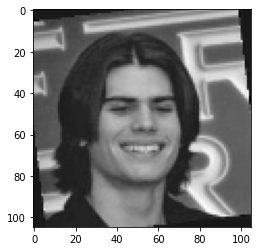

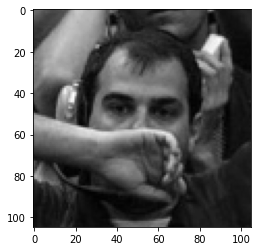

the same person


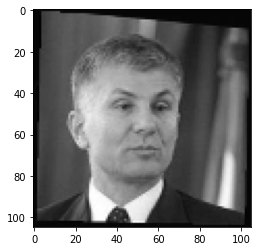

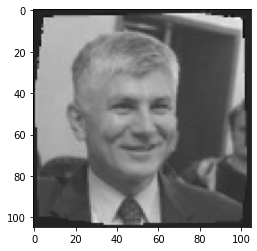

model corrct
the same person


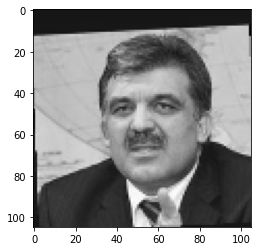

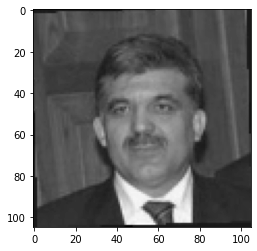

two different persons


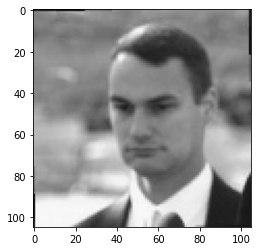

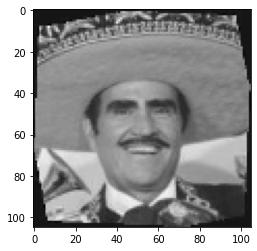

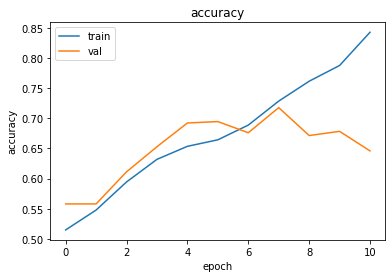

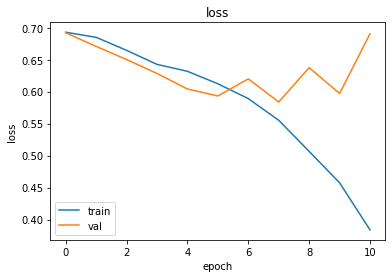

In [ ]:
main()